In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import os.path
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import csv


warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

physical_dev = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs avail: ", len(physical_dev))
tf.config.experimental.set_memory_growth(physical_dev[0], True)
#tf.debugging.set_log_device_placement(True)


#Data org
os.chdir('C:/venv/tensorflow-scripting/data/lung-scans')

if os.path.isdir('train/healthy') is False:
    os.makedirs('train/healthy')
    os.makedirs('train/bacterial')
    os.makedirs('train/viral')
    os.makedirs('valid/healthy')
    os.makedirs('valid/bacterial')
    os.makedirs('valid/viral')
    os.makedirs('test/healthy')
    os.makedirs('test/bacterial')
    os.makedirs('test/viral')

    

#Weirdness with rel path
CURR_DIR = os.getcwd()
print(CURR_DIR)

'''
class_id = 0 if the image corresponds to a subject without disease (normal)

class_id = 1 if the image corresponds to a patient with bacterial pneumonia

class_id = 2 if the image corresponds to a patient with viral pneumonia
'''

with open('labels/labels_train.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
#HEALTHY
        if(row['class_id'] == '0'):
            if(len([name for name in os.listdir(CURR_DIR + '/train/healthy/')
                if os.path.isfile(os.path.join(CURR_DIR + '/train/healthy/', name))]) < 800):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/train/healthy/')
            elif(len([name for name in os.listdir(CURR_DIR + '/valid/healthy/')
                if os.path.isfile(os.path.join(CURR_DIR + '/valid/healthy/', name))]) < 100):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/healthy/')
            elif(len([name for name in os.listdir(CURR_DIR + '/test/healthy/')
                if os.path.isfile(os.path.join(CURR_DIR + '/test/healthy/', name))]) < 50):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/test/healthy/')
#BACTERIAL
        if(row['class_id'] == '1'):
            if(len([name for name in os.listdir(CURR_DIR + '/train/bacterial/')
                if os.path.isfile(os.path.join(CURR_DIR + '/train/bacterial/', name))]) < 800):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/train/bacterial/')
            elif(len([name for name in os.listdir(CURR_DIR + '/valid/bacterial/')
                if os.path.isfile(os.path.join(CURR_DIR + '/valid/bacterial/', name))]) < 100):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/bacterial/')
            elif(len([name for name in os.listdir(CURR_DIR + '/test/bacterial/')
                if os.path.isfile(os.path.join(CURR_DIR + '/test/bacterial/', name))]) < 50):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/test/bacterial/')
#VIRAL                        
        if(row['class_id'] == '2'):
            if(len([name for name in os.listdir(CURR_DIR + '/train/viral/')
                if os.path.isfile(os.path.join(CURR_DIR + '/train/viral/', name))]) < 800):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/train/viral/')
            elif(len([name for name in os.listdir(CURR_DIR + '/valid/viral/')
                if os.path.isfile(os.path.join(CURR_DIR + '/valid/viral/', name))]) < 100):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/viral/')
            elif(len([name for name in os.listdir(CURR_DIR + '/test/viral/')
                if os.path.isfile(os.path.join(CURR_DIR + '/test/viral/', name))]) < 50):
                file = '/train_images/' + row['file_name']
                shutil.copy(CURR_DIR + file, CURR_DIR + '/test/viral/')                   

os.chdir('../../')

   




Num GPUs avail:  1
C:\venv\tensorflow-scripting\data\lung-scans


Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

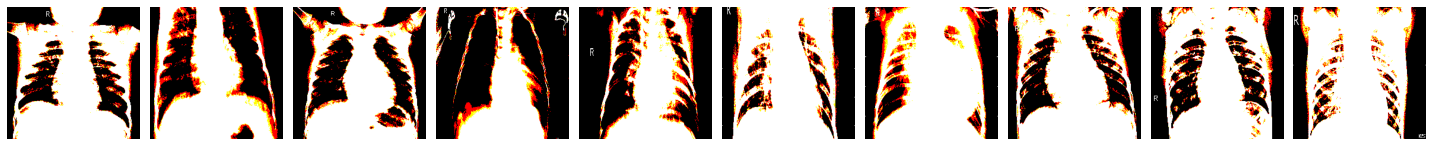

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [5]:
train_path = 'data/lung-scans/train'
valid_path = 'data/lung-scans/valid'
test_path = 'data/lung-scans/test'

#ok, this preproc looks wack
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory = train_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'],  batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory = valid_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'],  batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory = test_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'], batch_size = 10, shuffle = False)

assert train_batches.n == 2400
assert valid_batches.n == 300
assert test_batches.n == 150
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)


In [4]:

#TRAINING VGG16
vgg16_model = tf.keras.applications.vgg16.VGG16()

#vgg16_model.summary()
#Loop through every except last vgg16 classifies 1000 classes.( we need only 3) and add them to the new model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
#model.summary()

#for layer in model.layers:
#    layer.trainable = False

model.add(Dense(units = 3, activation = 'softmax'))

#model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(x = train_batches, validation_data = valid_batches, epochs = 5, verbose = 2)



Epoch 1/5
240/240 - 35s - loss: 1.0703 - accuracy: 0.5050 - val_loss: 0.7807 - val_accuracy: 0.6533
Epoch 2/5
240/240 - 34s - loss: 0.6525 - accuracy: 0.7067 - val_loss: 0.7511 - val_accuracy: 0.7033
Epoch 3/5
240/240 - 34s - loss: 0.5416 - accuracy: 0.7729 - val_loss: 0.5976 - val_accuracy: 0.7300
Epoch 4/5
240/240 - 34s - loss: 0.4842 - accuracy: 0.7983 - val_loss: 0.7118 - val_accuracy: 0.6800
Epoch 5/5
240/240 - 35s - loss: 0.4631 - accuracy: 0.7992 - val_loss: 0.5511 - val_accuracy: 0.7700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

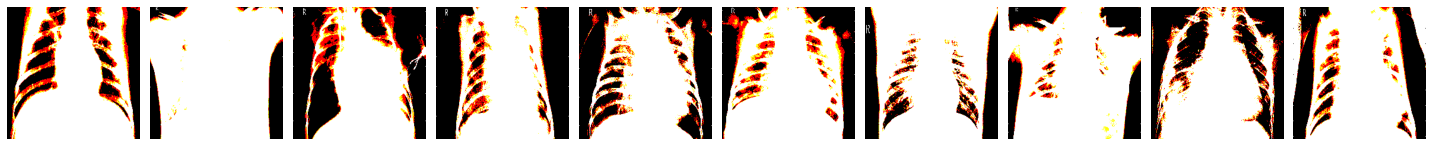

Confusion matrix, without norm
[[38  2 10]
 [ 4 43  3]
 [14  1 35]]


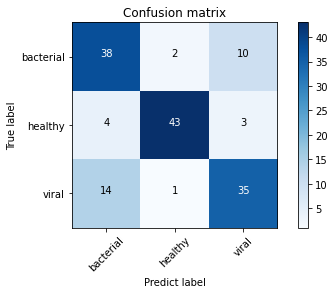

In [6]:
#PREDICTING
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
predictions = model.predict(x=test_batches, verbose = 0)
test_batches.classes
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))
test_batches.class_indices
cm_plot_labels = ['bacterial', 'healthy', 'viral']




def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Cunfusion matrix',
                          cmap = plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize  = True'.
    """
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without norm")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
            horizontalalignment = "center",
            color = "white" if cm[i,j] > thresh else "black")
            
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion matrix')